In [1]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns

# Get all analyzed STRs
all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","str.start","end"])
all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)

# Load other "distances"
ANNOTDIR = "/storage/mgymrek/gtex/annotations"
acc = pd.read_csv(os.path.join(ANNOTDIR, "acceptorsites_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.acc"])
donor = pd.read_csv(os.path.join(ANNOTDIR, "donorsites_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.donor"])

# Get causal/best per gene for each tissue
DATADIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
OUTPATH = "pdfs/"
TISSUES = [
    'Brain-Caudate(basalganglia)',
    'Brain-Cerebellum',
         'Muscle-Skeletal',
    'Cells-Transformedfibroblasts',
     'Esophagus-Mucosa',
     'Skin-NotSunExposed(Suprapubic)',
     'Skin-SunExposed(Lowerleg)',
     'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Adipose-Subcutaneous',
    'Adipose-Visceral(Omentum)',
     'Lung',
     'Thyroid',
     'Nerve-Tibial',
     'Heart-LeftVentricle',
     'WholeBlood',
]
data = {}
for t in TISSUES:
    x = pd.read_csv(os.path.join(DATADIR, t, "Master.table"), sep="\t")
    data[t] = x 

# Get motifs
hipmotifs = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed", sep="\t", names=["chrom","str.start","str.end","period","motif"])
all_strs = pd.merge(all_strs, hipmotifs, on=["chrom","str.start"])
hipmotifs_s = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed", sep="\t",
                         names=["chrom","start","end","period","motif_pos","motif_neg"])
hipmotifs_s["str.start"] = hipmotifs_s["start"]
allmotifs = set(hipmotifs_s["motif_pos"])

Populating the interactive namespace from numpy and matplotlib


# Dist to TSS (TES, splice, etc.) analysis

In [2]:
def GetTss(x):
    if x["gene.strand"]=="+": return x["str.start"]-x["gene.start"]
    else: return -1*(x["str.start"]-x["gene.stop"])
def GetTes(x):
    if x["gene.strand"]=="+": return x["str.start"]-x["gene.stop"]
    else: return -1*(x["str.start"]-x["gene.start"])
def GetMotif(x):
    if x["gene.strand"]=="+": return x["motif_pos"]
    else: return x["motif_neg"]

In [38]:
x = data["WholeBlood"]
x[x["top.variant"].apply(lambda x: "SNP" not in x) & (x["motif"].apply(lambda x: len(x))==6) & (x["qvalue"]<=0.05)].sort_values("best.str.score", ascending=False)[["chrom","str.start","gene.name","gene","motif","qvalue","best.str.score"]]

,chrom,str.start,gene.name,gene,motif,qvalue,best.str.score
9028,chr11,116927253,PAFAH1B2,ENSG00000168092.9,AGATAT,0.024098,0.061891


ALL
AC
GT
CG
AT
4
3
ATrich
AGrich
ACrich
A
T


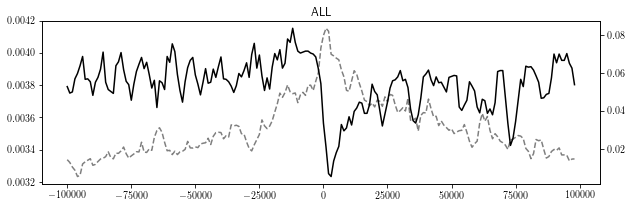

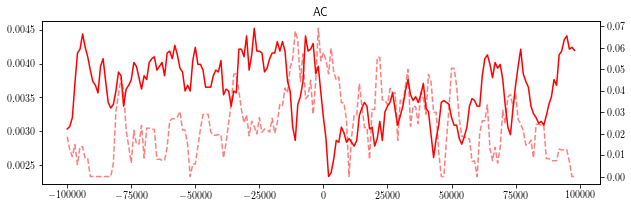

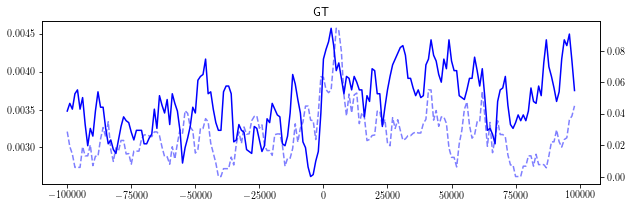

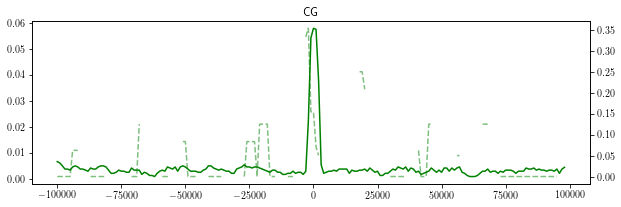

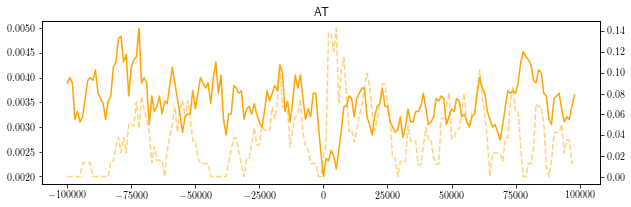

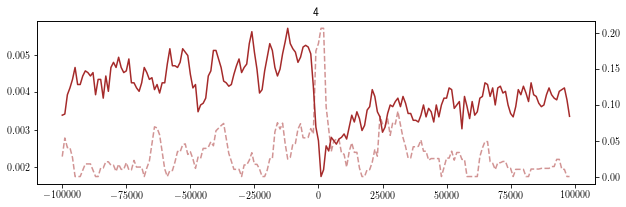

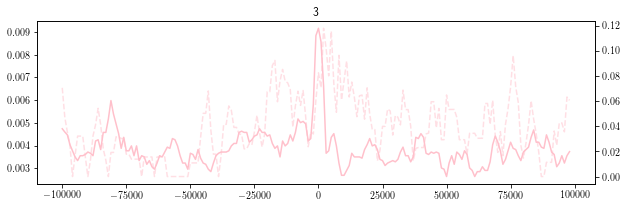

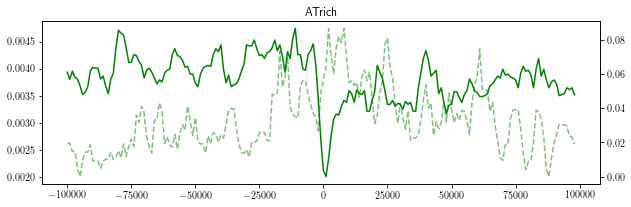

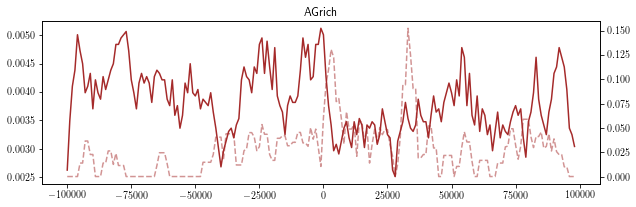

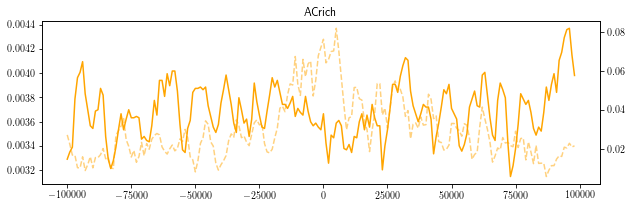

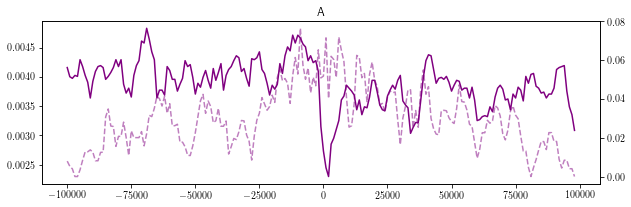

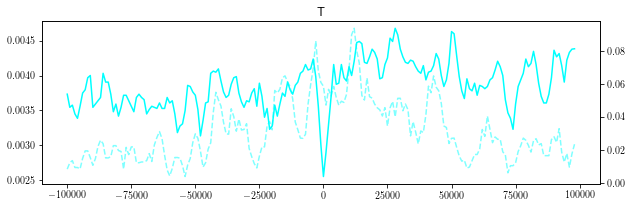

In [10]:
t = "Cells-Transformedfibroblasts"
d = pd.read_csv(os.path.join(DATADIR, t, "Lin_Reg_Out"), sep="\t")
d = pd.merge(d, acc[["chrom","str.start","dist.acc"]], on=["chrom","str.start"])
d = pd.merge(d, donor[["chrom","str.start","dist.donor"]], on=["chrom","str.start"])

geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot[["gene.id"]]
d = pd.merge(geneannot[["gene","gene.strand","gene.start","gene.stop"]], d, on =["gene"])
d["dist.tss"] = d.apply(lambda x: GetTss(x), 1)
d["dist.tes"] = d.apply(lambda x: GetTes(x), 1)
d = pd.merge(d, hipmotifs_s[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])
d["motif"] = d.apply(lambda x: GetMotif(x), 1)
d["is.estr"] = (d["p.wald"]<0.01) # TODO change by getting real eSTR definition. also get causal

MAXQ = 0.1
MINSCORE = 0.01
d["locus"] = d.apply(lambda x: x["gene"]+":"+str(x["str.start"]), 1)
x = data[t]
x["locus"] = x.apply(lambda x: x["gene"]+":"+str(x["str.start"]), 1)
x_estrs = set(x[(x["qvalue"]<=MAXQ)]["locus"])
x_cestrs = set(x[(x["qvalue"]<=MAXQ) & (x["best.str.score"]>=MINSCORE)]["locus"])
#d["is.estr"] = d["locus"].apply(lambda x: x in x_estrs)
#d["is.c"] = d["locus"].apply(lambda x: x in x_cestrs)
d["is.estr"] = d["p.wald"]<0.001 # TODO update definition.
# TODO why some genes missing in master.table

num = {}
p = {}
direction = {}

keys = ["ALL","AC","GT","CG","AT","4","3","ATrich","AGrich","ACrich","A","T"]
othermotifs = {
    "AC": ["AC"],
    "GT": ["GT"],
    "CG": ["CG","CCG","CCCG","CCCCG","CCCCCG","CGG","CGGG","CGGGG","CGGGGG"],
    "AT": ["AT"],
    "AG": ["AG"],
    "AGG": ["AGG"],
    "A": ["A"],
    "T": ["T"],
    "4": ["AAAT","AAAC","AAAG","AATG","ATAG","CATT"],
    "3": [item for item in allmotifs if len(item)==3],
    "ATrich": ["AT","AAT","AAAT","ATT","ATTT"],
    "AGrich": ["AG","CT","AAG","CTT","AAAG","CTTT","AGG","CCT","AGGG","CCCT"],
    "ACrich": ["AC","GT","AAC","GTT","AAAC","GTTT","ACC","GGT","ACCC","GGGT"]
}


col = "dist.tss"
bins = np.arange(-100000, 100000, 1000)
if col in ["dist.acc","dist.donor"]:
    bins = np.arange(-5000, 5000, 100)

for key in keys:
    print(key)
    total = d.shape[0]
    if key != "ALL": total = d[d["motif"].apply(lambda x: x in othermotifs[key])].shape[0]
    num[key] = []
    p[key] = []
    direction[key] = []
    for i in range(len(bins)-1):
        lb = bins[i]
        ub = bins[i+1]
        x = d[(d[col]>=lb) & (d[col]<ub) ]
        if key != "ALL":
            x = x[x["motif"].apply(lambda x: x in othermotifs[key])]
        direction[key].append(np.mean(x[x["is.estr"]]["beta"].apply(lambda x: int(x>0))))
        num[key].append(x.shape[0]*1.0/total)
        p[key].append(np.mean(x["is.estr"]))

def Smooth(x, buf=2):
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

colors = {
    "ALL": "black",
    "AC": "red",
    "GT": "blue",
    "CG": "green",
    "AT": "orange",
    "AG": "purple",
    "AGG": "purple",
    "4": "brown",
    "3": "pink",
    "ATrich": "green",
    "ACrich": "orange",
    "AGrich": "brown",
    "A": "purple",
    "T": "cyan"
}

buf = 2
for key in keys:
    fig = plt.figure()
    fig.set_size_inches((10, 3))
    ax = fig.add_subplot(111)
    ax.plot(bins[:-1], Smooth(num[key], buf=buf), color=colors[key])
    ax2 = ax.twinx()
    ax2.plot(bins[:-1], Smooth(p[key], buf=buf), color=colors[key], linestyle="dashed", alpha=0.5)
    ax.set_title(key)
    fig.savefig(os.path.join(OUTPATH, "%s.%s.pdf"%(key, col)))

# overall motif enrichment

In [4]:
MAXQ = 0.1
MINSCORE = 0.1

# Get top motifs to include 
motifs = all_strs.groupby("motif", as_index=False).agg({"str.start":len})
motifs = list(motifs[motifs["str.start"]>=25].sort_values("str.start")["motif"])
num_motifs = len(motifs)
num_tissues = len(TISSUES)


# Get matrices of tissue by motif for: OR_enrich, P_enrich, %_direction, P_direction
def NormTable(t, total):
    t[1][1] = total-sum(t)
    return t

OR_e_all = np.zeros((num_motifs, num_tissues))
P_e_all = np.zeros((num_motifs, num_tissues))
OR_ec_all = np.zeros((num_motifs, num_tissues))
P_ec_all = np.zeros((num_motifs, num_tissues))

dir_e_all = np.zeros((num_motifs, num_tissues))
dirP_e_all = np.zeros((num_motifs, num_tissues))
dir_ec_all = np.zeros((num_motifs, num_tissues))
dirP_ec_all = np.zeros((num_motifs, num_tissues))

num_all = all_strs.shape[0]
for i in range(num_tissues):
    x = data[TISSUES[i]]
    x["is.estr"] = x["qvalue"]<=MAXQ
    x["is.cestr"] = (x["qvalue"]<=MAXQ) & (x["top.variant"].apply(lambda x: "SNP" not in x))
    num_estr = sum(x["is.estr"])
    num_cestr = sum(x["is.cestr"])
    for j in range(num_motifs):
        num_estr_m = x[(x["is.estr"]) & (x["motif"]==motifs[j])].shape[0]
        num_cestr_m = x[(x["is.cestr"]) & (x["motif"]==motifs[j])].shape[0]
        num_all_m = all_strs[all_strs["motif"]==motifs[j]].shape[0]
        
        t1 = [[num_estr_m, num_estr-num_estr_m],
             [num_all_m, 0]]
        t1 = NormTable(t1, num_all)
        t2 = [[num_cestr_m, num_cestr-num_cestr_m],
             [num_all_m, 0]]
        t2 = NormTable(t2, num_all)
        odds1, p1 = scipy.stats.fisher_exact(t1)
        odds2, p2 = scipy.stats.fisher_exact(t2)
        OR_e_all[j][i] = odds1
        P_e_all[j][i] = p1
        OR_ec_all[j][i] = odds2
        P_ec_all[j][i] = p2
        
        dir1x = np.array(x[(x["is.estr"]) & (x["motif"]==motifs[j])]["beta"].apply(lambda x: int(x>0)))
        dir_e_all[j][i] = np.mean(dir1x)
        dirP_e_all[j][i] = scipy.stats.binom_test(n=len(dir1x), p=0.5, x=sum(dir1x))
        dir2x = np.array(x[(x["is.cestr"]) & (x["motif"]==motifs[j])]["beta"].apply(lambda x: int(x>0)))
        dir_ec_all[j][i] = np.mean(dir2x)
        dirP_ec_all[j][i] = scipy.stats.binom_test(n=len(dir2x), p=0.5, x=sum(dir2x))

/usr/lib64/python3.4/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log2


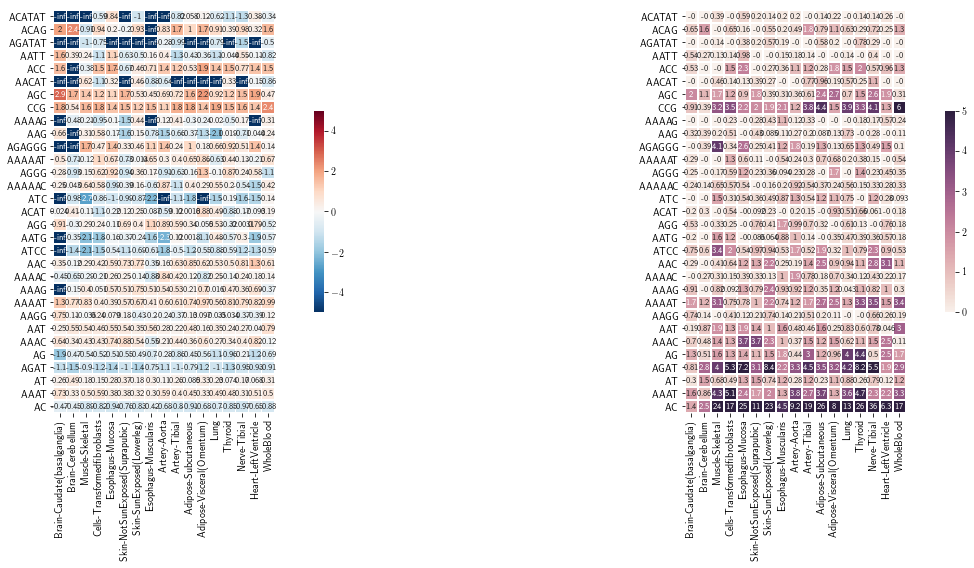

In [5]:
#fig, ax = plt.subplots(figsize=(10, 8))
fig = plt.figure()
fig.set_size_inches((20,8))
ax = fig.add_subplot(121)
#cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(np.log2(OR_e_all), annot=True, annot_kws={"size": 8},
            vmin=-5, vmax=5, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=TISSUES, 
           yticklabels=motifs);

ax = fig.add_subplot(122)
#fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(-1*np.log10(P_e_all), annot=True, annot_kws={"size": 8},
            vmin=0, vmax=5, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=TISSUES, 
           yticklabels=motifs);
fig.tight_layout()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2


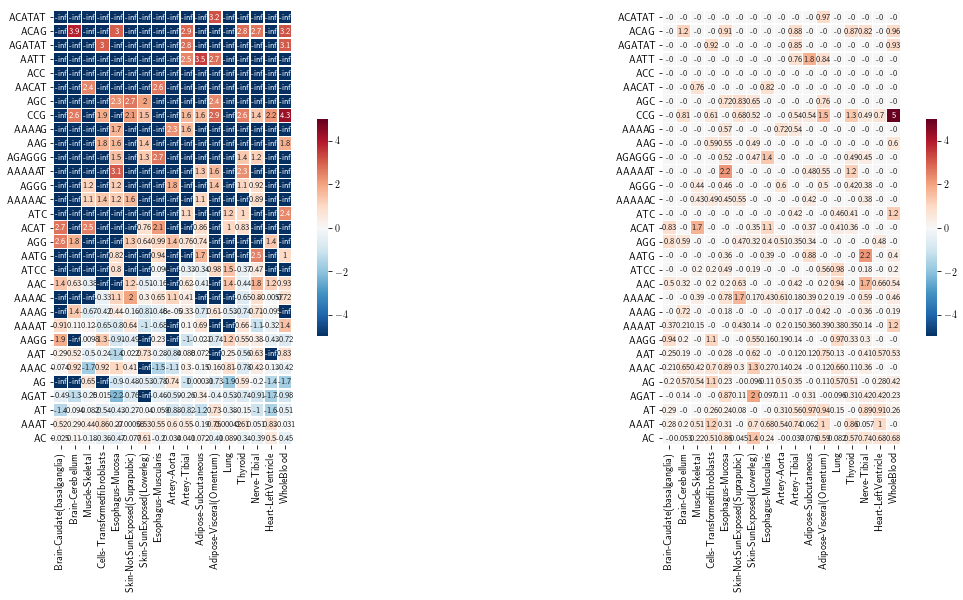

In [6]:
fig = plt.figure()
fig.set_size_inches((20,8))
ax = fig.add_subplot(121)
#cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(np.log2(OR_ec_all), annot=True, annot_kws={"size": 8},
            vmin=-5, vmax=5, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=TISSUES, 
           yticklabels=motifs);

ax = fig.add_subplot(122)
sns.heatmap(-1*np.log10(P_ec_all), annot=True, annot_kws={"size": 8},
            vmin=-5, vmax=5, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=TISSUES, 
           yticklabels=motifs);

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


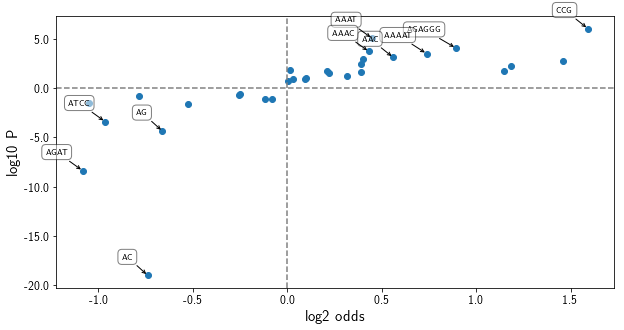

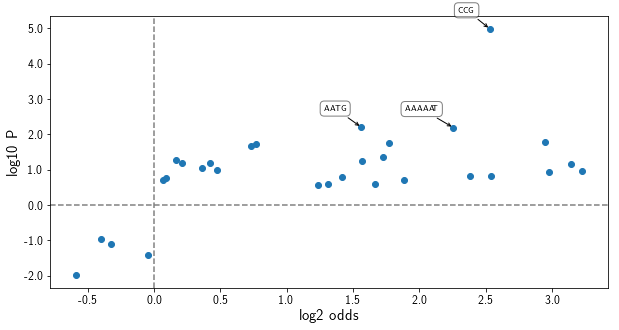

In [7]:
def FisherP(x):
    chi2 = -2*sum([np.log(item) for item in x])
    return 1-scipy.stats.chi2(2*len(x)).cdf(chi2)

def PlotSummary(ORm, Pm, pthresh, motifs, logOR=True):
    if logOR:
        odds_ratios = np.log2(np.nanmean(ORm, 1))
    else: odds_ratios = np.mean(ORm, 1)
    #pvals = [FisherP(Pm[i,:]) for i in range(Pm.shape[0])]
    pvals = np.min(Pm, 1) # best pval
    d = pd.DataFrame({"motif": motifs, "OR": odds_ratios, "P": pvals})
    if logOR:
        d["sign"] = d["OR"].apply(lambda x: [-1,1][int(x>0)])
    else:
        d["sign"] = d["OR"].apply(lambda x: [-1,1][int(x>0.5)])
    d["signp"] = d.apply(lambda x: -1*np.log10(x["P"]+10e-20)*x["sign"], 1)
    d = d.sort_values("OR", ascending=False)
    d = d[~(abs(d["OR"]) == np.inf)]
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    ax = fig.add_subplot(111)
    ax.scatter(d["OR"], d["signp"])
    ax.set_xlabel("log2 odds", size=15)
    ax.set_ylabel("log10 P", size=15)

    for label, x, y in zip(d["motif"], d["OR"], d["signp"]):
        if 10**(-1*abs(y))>pthresh: continue
        plt.annotate(
            label,
            xy=(x, y), xytext=(-15, 15), size=8,
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.axhline(y=0, linestyle="dashed", color="gray")
    ax.axvline(x=0, linestyle="dashed", color="gray");
    
OR_e_all[OR_e_all==0] = np.nan
OR_ec_all[OR_ec_all==0] = np.nan

PlotSummary(OR_e_all, P_e_all, 0.001, motifs, logOR=True)
PlotSummary(OR_ec_all, P_ec_all, 0.01, motifs, logOR=True)